# Test Training Run Checkpoints Against a Random Agent to see if Training Succeeded

This notebook performs a basic check to compare each checkpoint of a training run against a random agent. If the training run is successful, we should observe improved performance over time.

In [7]:
CHKPT_DIR = 'chkpts_mcts_sims_100/'  # The path to the checkpoints directory
NUM_CHKPTS = 10                      # The number of checkpoints in the checkpoints directory
NUM_MCTS_SIMS = 100                  # This should match the number of MCTS simulations used during training
BOARD_SIZE = 4                       # This should match the board size used during training
SCORE_TARGET = 15                    # This should match the score target used during training
N_GAMES = 30                         # The number of games to play for each evaluation
CPUS = 4.0                           # Number of CPU cores to use

## Imports

In [8]:
import pickle
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt

import Arena
from MCTS import MCTS
from utils import *

from blooms.BloomsGame import BloomsGame
from blooms.BloomsPlayers import RandomPlayer
from blooms.pytorch.NNet import NNetWrapper as BloomsPyTorchNNet

## Evaluation Function

In [9]:
def evaluate_agent(n_games, game, opponent, chkpt_dir, chkpt_filename):
    """Compare the performance of an agent against an Opponent.
    """
    model = BloomsPyTorchNNet(game)
    model.load_checkpoint(chkpt_dir, chkpt_filename)
    args = dotdict({'numMCTSSims': NUM_MCTS_SIMS, 'cpuct': CPUS})
    mcts = MCTS(game, model, args)
    agent = lambda x: np.argmax(mcts.getActionProb(x, temp=0))

    arena = Arena.Arena(agent, opponent, game)
    wins, losses, draws = arena.playGames(n_games, verbose=False)
    
    return wins, losses, draws

## Evaluate Against a Random Agent

In [10]:
results_vs_random = []
for i, chkpt in enumerate(range(1, NUM_CHKPTS + 1)): 
    n_games = N_GAMES
    game = BloomsGame(size=BOARD_SIZE, score_target=SCORE_TARGET)

    random_agent = RandomPlayer(game).play

    wins, losses, draws = evaluate_agent(n_games, game, random_agent, CHKPT_DIR, f'checkpoint_{chkpt}.pth.tar')
    win_percentage = wins / n_games

    results_vs_random.append(win_percentage)
    
pickle.dump(results_vs_random, open(CHKPT_DIR + 'chkpt_evals_vs_random_agent.pkl', 'rb'))

Arena.playGames (2): 100%|██████████| 5/5 [01:59<00:00, 23.94s/it]


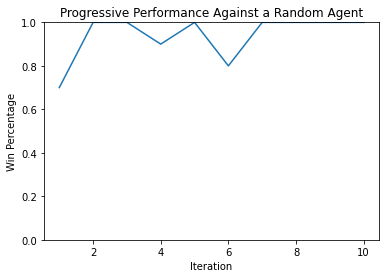

In [12]:
fig, ax = plt.subplots(1)

checkpoints = range(1, NUM_CHKPTS + 1)
plt.plot(checkpoints, results_vs_random)

plt.xlabel('Iteration')
plt.ylabel('Win Percentage')
plt.ylim(0, 1)
plt.title('Progressive Performance Against a Random Agent')
plt.show()